# Анализ сервиса проката самокатов GoFast

## Введение

GoFast - сервис аренды самокатов, работающий в нескольких городах России. Для совершения поездки пользователь арендует самокат через собственное мобильное приложение сервиса. Возможны два варианта аренды: с подпиской Ultra и без подписки. Подробные условия приведены в таблице:

|Условия|Без подписки|С подпиской Ultra|
|-|--------|---|
|Абонентская плата|отсутствует|199 рублей|
|Стоимость одной минуты поездки|8 рублей|6 рублей|
|Стоимость старта|50 рублей|бесплатно|



### Цели анализа
1. Установить, кто пользуется сервисом.
2. Установить, какие факторы влияют на выручку сервиса.  

Результаты работы могут быть использованы для повышение рентабельности бизнеса.

### Задачи, решаемые в ходе анализа
1. Предварительная обработка данных.  
Под обработкой подразумевается:
- приведение типа данных к нужному типу,
- обработка пропусков,
- обработка дубликатов.
2. Выполнение визуализации данных:
- распределение пользователей по городам,
- соотношение пользователей с подпиской и без неё,
- распределение пользователей по возрасту,
- распределение продолжительности поездок,
- распределение дистанции поездок.
3. Подсчет помесячной выручки от пользователей с подпиской и без подписки.
4. Проверка гипотез касательно сервиса:
- тратят ли пользователи с подпиской больше времени на поездки,
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров,
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

### Описание начальных данных   


Для анализа предоставлены три таблицы с данными.
1. Таблица с информацией о пользователях (файл "users_go.csv").

|Столбец|Описание|
|-|--------|
|user_id|уникальный идентификатор пользователя|
|name|имя пользователя|
|age|возраст|
|subscription_type|тип подписки (free, ultra)|

2. Таблица с информацией о поездках (файл "rides_go.csv").

|Столбец|Описание|
|-|--------|
|user_id|уникальный идентификатор пользователя|
|distance|расстояние, которое проехали в текущей сессии (в метрах)|
|duration|продолжительность сессии (в минутах)|
|date|дата совершения поездки|


3. Таблица с информацией о подписках (файл "subscriptions_go.csv").

|Столбец|Описание|
|-|--------|
|subscription_type|тип подписки|
|minute_price|стоимость одной минуты поездки|
|start_ride_price|стоимость начала поездки|
|subscription_fee|стоимость ежемесячного платежа|

### План работы
1. Загрузка данных.
2. Предварительная обработка.  
3. Выполнение визуализации в соответствии с задачами.
4. Подсчет помесячной выручки от пользователей с подпиской и без подписки.
5. Проверка ряда гипотез.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

## Шаг 1. Загрузка данных

Загрузим и оценим данные, предоставленные для анализа.

In [ ]:
dt_users = pd.read_csv('/datasets/users_go.csv')  # Пользователи
dt_rides = pd.read_csv('/datasets/rides_go.csv')  # Поездки
dt_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')  # Подписки

In [ ]:
dt_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [ ]:
dt_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Пропусков нет.

In [ ]:
dt_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [ ]:
dt_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Пропусков нет, но надо изменить тип данных в столбце date.

In [ ]:
dt_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [ ]:
dt_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Итог:** данные загружены, пропуску не обнаружены.

## Шаг 2. Предобработка данных

### Сперва приведем дату в нужный тип

In [ ]:
dt_rides['date'] = pd.to_datetime(dt_rides['date'], format='%Y-%m-%d')
dt_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


**Итог:** Тип данных изменен.

### Создание нового столбца с номером месяца на основе столбца date

Создадим столбец с номером месяца.

In [ ]:
dt_rides['month'] = dt_rides['date'].dt.month
dt_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [ ]:
dt_rides['month'].unique()

array([ 1,  4,  8, 10, 11, 12,  3,  6,  7,  2,  5,  9])

Представлена информация за все месяцы года.

In [ ]:
dt_rides['date'].max()

Timestamp('2021-12-30 00:00:00')

In [ ]:
dt_rides['date'].min()

Timestamp('2021-01-01 00:00:00')

В предоставленных данных содержится только информация за 2021 год. В связи с этим, можно группировать данные по месяцам: в один и тот же месяц не будут посчитаны данные за разные года.

**Итог:** столбец создан.  
Присутствуют данные только за 2021 год.


### Обработка дубликатов в датафреймах

Как видно из раздела 2, пропусков не было, поэтому проверим на дубликаты. Начнем с таблицы о пользователях.

In [ ]:
dt_users.duplicated().sum()

31

31 полный дубликат. Учитывая, что всего в таблице 1565 значений, удаление 31 строки не должно серьезно ухудшить анализ.

In [ ]:
dt_users = dt_users.drop_duplicates(keep='first')
dt_users.duplicated().sum()

0

In [ ]:
dt_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


Явные дубликаты удалены. Посмотрим, не присвоен ли один и тот же user_id разным людям.

In [ ]:
dt_users['user_id'].value_counts()

1       1
1020    1
1029    1
1028    1
1027    1
       ..
510     1
509     1
508     1
507     1
1534    1
Name: user_id, Length: 1534, dtype: int64

Дубликатов нет. Теперь проверим дубликаты в таблице с поездками.

In [ ]:
dt_rides.duplicated().sum()

0

Явных полных дубликатов нет. У одного и того же пользователя могут быть одинаковые поездки, поэтому по каждому столбцу отдельно не требуется проверка.  
Таблица с подписками состоит всего из двух строк и там дубликатов нет.

**Итог:** пропуски и дубликаты удалены.

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов

Визуализируем частоту встречаемости городов.

In [ ]:
dt_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

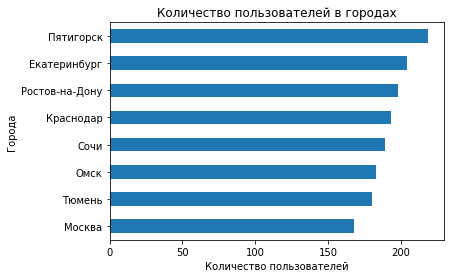

In [ ]:
dt_users['city'].value_counts(ascending=True).plot(kind="barh")
plt.title('Количество пользователей в городах')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.show()

In [ ]:
dt_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Как видно из графика, больше всего пользователей из Пятигорска.

**Итог:** визуализация сделана.

### Соотношение пользователей с подпиской и без подписки

Сперва посмотрим, какая доля каждого типа подписки в общей доле пользователей.

In [ ]:
dt_users.loc[dt_users['subscription_type'] == 'free']['subscription_type'].count() / dt_users['subscription_type'].count()

0.5443285528031291

Доля пользователей без подписки составляет примерно 54%.

In [ ]:
dt_users.loc[dt_users['subscription_type'] == 'ultra']['subscription_type'].count() / dt_users['subscription_type'].count()

0.4556714471968709

Доля пользователей с подпиской Ultra составляет примерно 46%. Посмотрим их соотношение.

In [ ]:
dt_users.loc[dt_users['subscription_type'] == 'free']['subscription_type'].count() / dt_users.loc[dt_users['subscription_type'] == 'ultra']['subscription_type'].count()

1.1945636623748213

Пользователей без подписки больше, чем пользователей с подпиской Ultra примерно в 1,2 раза. Визуализируем данные.

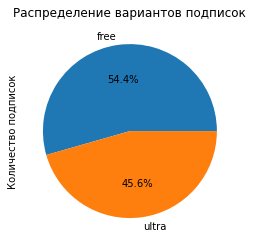

In [ ]:
dt_users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение вариантов подписок')
plt.ylabel('Количество подписок')
plt.show()

**Итог:** визуализация сделана. Как видно, пользователей с подпиской Ultra меньше, чем пользователей без подписки.

### Возраст пользователей

Сделаем распределение пользователей по возрасту.

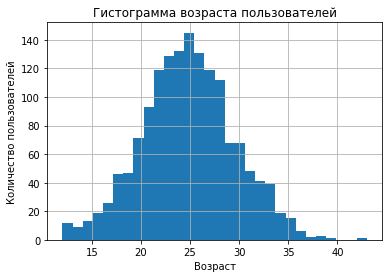

In [ ]:
dt_users['age'].hist(bins=30)
plt.title('Гистограмма возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

In [ ]:
dt_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Из гистограмму видно, что средний возраст пользователя сервиса - 25 лет. Максимальный возраст пользователя - 43 года, минимальный - 12 лет.

**Итог:** визуализация сделана.

### Расстояние, которое пользователь преодолел за одну поездку

Сделаем распределение по поездкам пользователей.

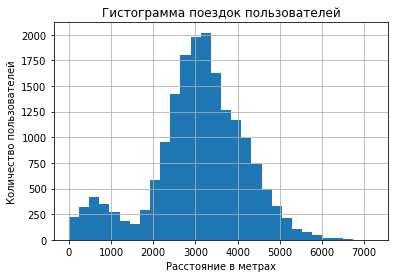

In [ ]:
dt_rides['distance'].hist(bins=30)
plt.title('Гистограмма поездок пользователей')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.show()

In [ ]:
dt_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Среднее расстояние, на которое совершают поездки: 3100 м или 3,1 км. При этом среднее и медианные значения значительно не отличаются, соответственно выбросы не сильно влияют на данные.

Небольшой пик в районе 600-700 метрах скорее всего связан с теми пользователями, которые взяли самокат в аренду первый раз с целью попробовать и оценить удобство использования.

**Итог:** визуализация сделана.

### Продолжительность поездок

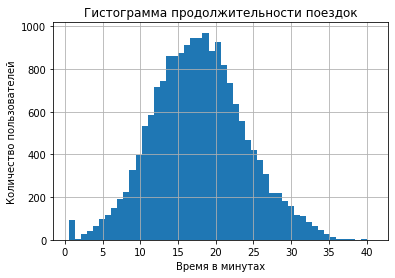

In [ ]:
dt_rides['duration'].hist(bins=50)
plt.title('Гистограмма продолжительности поездок')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.show()

In [ ]:
dt_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее время поездки составляет 17,7 минуты или 0,3 часа. Таким образом, средняя скорость, с которой перемещаются пользователи, составляет 10,3 км/ч.

Посмотрим на строки, в которых продолжительность поездки менее 2 минут.

In [ ]:
dt_rides.query('duration <= 2')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [ ]:
dt_rides.query('duration <= 2')['distance'].min()

4030.308008428866

Таких строк 95, время 0,5 минут, а минимальное расстояние 4030 метров. За 0,5 минут такое расстояние на самокате проехать невозможно. Вероятно, ошибка при формировании данных, но в целях сохранения значений выручки оставим данные строки.

**Итог:** Визуализация сделана. Строки с аномальными значениями удалены.

## Шаг 4. Объединение данных

### Объединение данных о пользователях, поездка и подписках в один датафрейм

In [ ]:
dt_rides_users = dt_rides.merge(dt_users, on='user_id', how='left')
dt_rides_users.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra


In [ ]:
total_data = dt_rides_users.merge(dt_subscriptions, on='subscription_type', how='left')
total_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Количество строк совпадает с количеством строк в самом большом изначальном датафрейме: dt_rides, следовательно потерянных строк нет. Пропусков в столбцах также нет.

**Итог:** датафрейм создан.

### Создание двух датафреймов: один о пользователях без подписки, второй о пользователях с подпиской

Создадим два датафрейма для каждого типа подписок.

In [ ]:
free_users = total_data.loc[total_data['subscription_type'] == 'free']
free_users.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [ ]:
ultra_users = total_data.loc[total_data['subscription_type'] == 'ultra']
ultra_users.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


**Итог:** датафреймы созданы.

### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

Сперва посмотрим на разницу в расстояниях.

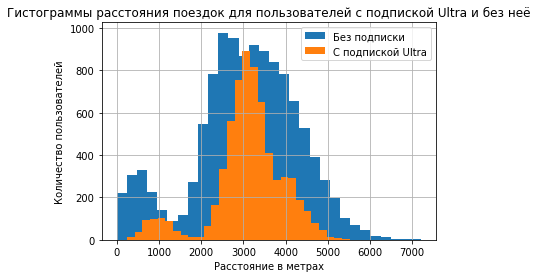

In [ ]:
free_users['distance'].hist(bins=30)
ultra_users['distance'].hist(bins=30)
plt.title('Гистограммы расстояния поездок для пользователей с подпиской Ultra и без неё')
plt.legend(['Без подписки', 'С подпиской Ultra'])
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.show()

In [ ]:
free_users['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [ ]:
ultra_users['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Для пользователей с подпиской ultra распределение более узкое, однако среднее расстояние между пользователями с подпиской и без подписки примерно одинаковое.

Теперь посмотрим на продолжительность поездок.

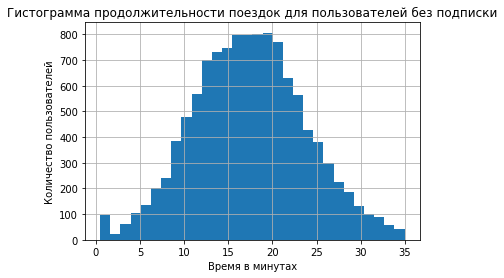

In [ ]:
free_users['duration'].hist(bins=30)
plt.title('Гистограмма продолжительности поездок для пользователей без подписки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.show()

Теперь посмотрим на распределение пользователей с подпиской Ultra.

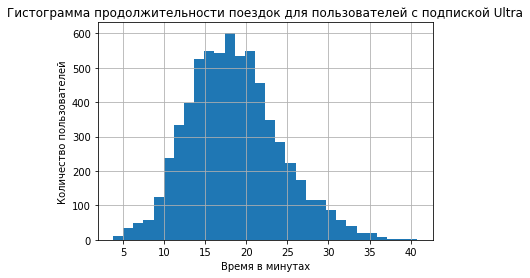

In [ ]:
ultra_users['duration'].hist(bins=30)
plt.title('Гистограмма продолжительности поездок для пользователей с подпиской Ultra')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.show()

In [ ]:
free_users['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [ ]:
ultra_users['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Распределение опять более узкое, хоть и в меньшей степени. Наблюдается небольшое отклонение. Люди с подпиской Ultra немного дольше едут, чем люди без подписки. Это видно по среднему и по медиане.

**Итог:** визуализация сделана.

## Шаг 5. Подсчёт выручки

### Создание датафрейма с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4

Необходимо сделать датафрейм с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц года.  
Сперва округлим продолжительность поездок.

In [ ]:
total_data['round_duration'] = np.ceil(total_data['duration'])
total_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,round_duration
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199,26.0
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199,16.0
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199,7.0
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199,19.0
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199,27.0


In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
 12  round_duration     18068 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory 

Округление выполнено. Приступаем к созданию датафрейма.

In [ ]:
agr_group_1 = total_data.groupby(by=['user_id', 'month']).agg({'distance': 'sum', 'round_duration': ['sum', 'count']})
agr_group_1.head()

distance round_duration      
                       sum            sum count
user_id month                                  
1       1      7027.511294           42.0     2
        4       754.159807            7.0     1
        8      6723.470560           46.0     2
        10     5809.911100           32.0     2
        11     7003.499363           56.0     3

In [ ]:
agr_group_1.columns = ['distance', 'round_duration', 'count_rides']
agr_group_1.head()

distance  round_duration  count_rides
user_id month                                          
1       1      7027.511294            42.0            2
        4       754.159807             7.0            1
        8      6723.470560            46.0            2
        10     5809.911100            32.0            2
        11     7003.499363            56.0            3

In [ ]:
agr_group_2 = total_data.groupby(by=['user_id', 'month'])['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'].max()

In [ ]:
agr_group_data = agr_group_1.merge(agr_group_2, on=['user_id', 'month'], how='left')
agr_group_data.head()

distance  round_duration  count_rides subscription_type  \
user_id month                                                               
1       1      7027.511294            42.0            2             ultra   
        4       754.159807             7.0            1             ultra   
        8      6723.470560            46.0            2             ultra   
        10     5809.911100            32.0            2             ultra   
        11     7003.499363            56.0            3             ultra   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199

**Итог:** Датафрейм создан.

### Добавление в датафрейм столбцов с помесячной выручкой, которую принёс каждый пользователь

Посчитаем помесячную выручку и добавим новый столбец.  
Помесячная выручка считается по формуле: стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [ ]:
agr_group_data['revenue'] = agr_group_data['start_ride_price'] * agr_group_data['count_rides'] + agr_group_data['minute_price'] * agr_group_data['round_duration'] + agr_group_data['subscription_fee']
agr_group_data.head()

distance  round_duration  count_rides subscription_type  \
user_id month                                                               
1       1      7027.511294            42.0            2             ultra   
        4       754.159807             7.0            1             ultra   
        8      6723.470560            46.0            2             ultra   
        10     5809.911100            32.0            2             ultra   
        11     7003.499363            56.0            3             ultra   

               minute_price  start_ride_price  subscription_fee  revenue  
user_id month                                                             
1       1                 6                 0               199    451.0  
        4                 6                 0               199    241.0  
        8                 6                 0               199    475.0  
        10                6                 0               199    391.0  
        11                6                 0               199    535.0

**Итог:** Все столбцы созданы и рассчитаны.

## Шаг 6. Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки?

Сперва оценим среднее для каждой группы пользователей.

In [ ]:
total_data.loc[total_data['subscription_type'] == 'free']['round_duration'].mean()

17.890992392807746

In [ ]:
total_data.loc[total_data['subscription_type'] == 'ultra']['round_duration'].mean()

19.037692307692307

Согласно среднему, пользователи с Ultra-подпиской тратят времени меньше. Сформулируем нулевую и альтернативную гипотезы:  
**Нулевая гипотеза** - пользователи без подписки тратят времени на поездки столько же или меньше, чем пользователи с подпиской.  
**Альтернативная гипотеза** - пользователи с подпиской тратят больше времени на поездки.  
Уровень значимости установим в 0,05.  
Для проверки гипотезы воспользуемся двухвыборочным t-тестом для независимых выборок.

In [ ]:
alpha = 0.05

results_duration = st.ttest_ind(
    total_data.loc[total_data['subscription_type'] == 'ultra']['round_duration'],  # Выборка значений для пользователей с подпиской Ultra
    total_data.loc[total_data['subscription_type'] == 'free']['round_duration'],  # Выборка значений для пользователей без подписки
    alternative='greater')
if results_duration.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Отвергаем нулевую гипотезу.


По результатам проверки нулевая гипотеза отвергается, соответственно пользователи с подпиской Ultra ездят больше, чем пользователи без подписки.

**Итог:** Гипотеза не подтвердилась: люди с подпиской Ultra ездят в среднем столько же или меньше, чем пользователи без подписки.

### Не превышает ли расстояние, которое проезжают пользователи с подпиской, 3130 метров?

Посмотрим сперва на среднее и на медиану.

In [ ]:
total_data.loc[total_data['subscription_type'] == 'ultra']['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Согласно среднему, расстояние действительно не превышает 3130 метров, но при этом медиана выше. Сформулируем нулевую и альтернативную гипотезы:  
**Нулевая гипотеза** - пользователи с подпиской проезжают в среднем 3130 метров или меньше.    
**Альтернативная гипотеза** - пользователи с подпиской проезжают в среднем больше 3130 метров.  
Уровень значимости установим в 0,05.  
Для проверки гипотезы воспользуемся одновыборочным t-тестом.

In [ ]:
value = 3130

alpha = 0.05

results_distance = st.ttest_1samp(
    total_data.loc[total_data['subscription_type'] == 'ultra']['distance'], value,
    alternative='greater')

if results_distance.pvalue < alpha:
     print('Отвергаем гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Не получилось отвергнуть нулевую гипотезу.


**Вывод:** очевидно, нулевая гипотеза имеет право на существование. Однозначно нельзя сказать, что пользователи с подпиской Ultra ездят больше 3130 метров.

### Больше ли помесячная выручка от пользователей с подпиской, чем от пользователей без подписки?

Сперва посчитаем среднюю выручку для пользователей без подписки:

In [ ]:
agr_group_data.loc[agr_group_data['subscription_type'] == 'free']['revenue'].mean()

328.6413651073845

Теперь посчитаем среднюю выручку для пользователей с подпиской Ultra:

In [ ]:
agr_group_data.loc[agr_group_data['subscription_type'] == 'ultra']['revenue'].mean()

362.7921906022502

По среднему получается, что пользователи без подписки приносят выручки меньше, чем пользователи с подпиской.  
Сформулируем нулевую и альтернативную гипотезы:  
**Нулевая гипотеза** - пользователи без подписки приносят выручки столько же, как пользователи с подпиской или больше.  
**Альтернативная гипотеза** - пользователи с подпиской приносят больше выручки.  
Уровень значимости установим в 0,05.  
Для проверки гипотезы воспользуемся двухвыборочным t-тестом для независимых выборок.

In [ ]:
alpha = 0.05

results_revenue = st.ttest_ind(
    agr_group_data.loc[agr_group_data['subscription_type'] == 'ultra']['revenue'],  # выборка пользователей с подпиской Ultra
    agr_group_data.loc[agr_group_data['subscription_type'] == 'free']['revenue'],  # выборка пользователей без подписки
    alternative='greater')

if results_revenue.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Отвергаем нулевую гипотезу.


**Вывод:** Нулевая гипотеза не подтвердилась, соответственно скорее всего от пользователей с подпиской выручка больше.

### Какой тест понадобился бы, если бы техническая команда сервиса обновила сервера и предоставила бы файл для каждого пользователя с данными о количестве обращений до обновления и после него?

Для проверки гипотезы потребовался бы двухвыборочный t-тест для зависимых выборок (метод ```scipy.stats.ttest_rel()```).

## Шаг 7. Распределения

### Задача 1
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Так как мы знаем, что 10% продлевают подписку, то есть каждый десятый, то кажется логичным раздать в 10 раз больше промокодов, то есть 1000. Проверим это.

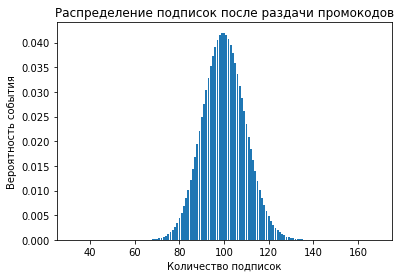

In [ ]:
n_0 = 1000  # количество промокодов
p = 0.1  # вероятность успеха

distr_promo_0 = []

for k in range(0, n_0 + 1):
    current_value = binom.pmf(k, n_0, p)
    distr_promo_0.append(current_value)

plt.bar(range(0, n_0 + 1), distr_promo_0)
plt.xlim(25, 175)
plt.title('Распределение подписок после раздачи промокодов')
plt.xlabel('Количество подписок')
plt.ylabel('Вероятность события')
plt.show()

По графику видно, что пик в районе 100 промокодов достигает 0,04 и делит вероятности точно пополам. Суммарное значение вероятностей левее пика больше, чем 5%.
Проверим кумулятивной функцией.

In [ ]:
distr_binom_0 = st.binom(n_0, p)

x_binom = 100

result_binom_0 = 1-distr_binom_0.cdf(x_binom)
result_binom_0

0.4734009187048347

Шанс не достичь 100 промокодов получается около 47%, что очень много. Подберем такое количество промокодов, при котором шанс выполнить план составит не менее 95%.

In [ ]:
n = 1000
p = 0.1
x_binom = 100
result_binom = 0.47

while result_binom < 0.95:
    distr_binom = st.binom(n, p)
    result_binom = 1-distr_binom.cdf(x_binom)
    n += 1

print('Количество промокодов:', n)
print('Шанс невыполнить план:', result_binom)

Количество промокодов: 1173
Шанс невыполнить план: 0.9504520478979693


Итого, для достижения плана необходимо раздать 1173 промокода, при этом шанс выполнить план составит 95%. Построим распределение:

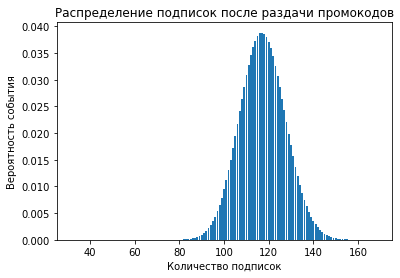

In [ ]:
distr_promo = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr_promo.append(current_value)

plt.bar(range(0, n + 1), distr_promo)
plt.xlim(25, 175)
plt.title('Распределение подписок после раздачи промокодов')
plt.xlabel('Количество подписок')
plt.ylabel('Вероятность события')
plt.show()

**Вывод:** чтобы набрать 100 продлений подписок нужно раздать более 1173 промокодов.

### Задача 2
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Попробуем сделать через аппроксимацию биномиального распределения нормальным распределением.

0.15371708296369768


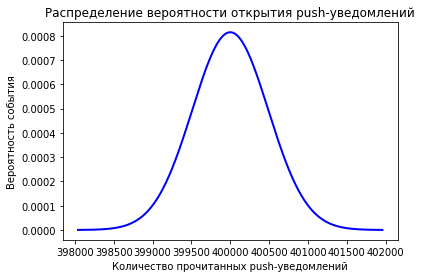

In [ ]:
# задаём параметры биномиального распределения
n_notif = 1000000
p_notif = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu_notif = n_notif * p_notif
sigma_notif = sqrt(n_notif * p_notif * (1 - p_notif))

# задаём нормальное распределение
distr_notif = st.norm(mu_notif, sigma_notif)

# считаем вероятность хвоста слева
result_notif = distr_notif.cdf(399500)
print(result_notif)

# cтроим график
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(int(num)):
        result.append(start + step * i)
    return result

left = int(mu_notif - 4 * sigma_notif)
right = int(mu_notif + 4 * sigma_notif)

x = linspace(left, right, 1000)
theplot = plt.subplot()
theplot.plot(x, norm.pdf(x, mu_notif, sigma_notif), 'b-', lw=2)

x_ticks = linspace(int(mu_notif - 3 * sigma_notif), int(mu_notif + 3 * sigma_notif), 3 * sigma_notif + 1)
theplot.set_xticks(x_ticks)
plt.xscale('linear')
plt.title('Распределение вероятности открытия push-уведомлений')
plt.xlabel('Количество прочитанных push-уведомлений')
plt.ylabel('Вероятность события')
plt.show()

**Вывод:** Вероятность, что откроют push-уведомление не более 399500 раз составляет 15,4 %.

## Заключение и общие выводы

### Обработка данных  

В рамках работы были обработаны данные из трех файлов:
- сведения о пользователях,
- сведения о поездках,
- сведения о подписках.  

В начальных данных пропусков не было обнаружено. Вместе с тем, в файле о поездках были найдены аномальные значения. Так, в файле было 95 строк, в которых расстояние поездки составляло более 4 километров, но время поездки было всего 0,5 минуты.

### Анализ данных и проверка гипотез.  

Были построены визуализации и определено следующее:
- больше всего пользователей сервиса из Пятигорска. Всего сервис представлен в 8 городах.
- среди пользователей сервиса большинство не пользуется подпиской (54%).
- сервисом пользуются люди от 12 до 43 лет.
- средняя дистанция, на которую совершают поездки, около 3 километров. При этом средняя скорость движения составляет 10 км/ч.  

Сформулированы и проверены следующие гипотезы:
- пользователи с подпиской тратят больше времени на поездки. Вывод: скорее всего, так и есть. Проверка гипотезы были осуществлена с помощью двухвыборочного t-теста для независимых выборок.
- пользователи с подпиской ездят меньшее, чем 3130 метров за одну поездку. Вывод: не удалось опровергнуть. Скорее всего, так и есть. Проверка гипотезы была осуществлена одновыборочным t-тестом.
- пользователи с подпиской приносят больше выручки, чем пользователи без подписки. Вывод: не удалось опровергнуть. Вероятно, пользователи с подпиской приносят больше выручки. Проверка гипотезы была осуществлена с помощью двухвыборочного t-теста для независимых выборок.  

Решены задачи:
- установлено необходимое количество промокодов: минимум 1173 промокода.
- установлена вероятность, что уведомления откроют менее 399 500 раз: 15,4%.

### Рекомендации по улучшению и уточнению анализа  


В целях уточнения результатов анализа рекомендуется:
- предоставить данные за другие временные промежутки.
- предоставить данные после модернизации приложения сервиса. О модернизации приложения говорилось в п. 7.4.
- проверить алгоритм сбора и выгрузки данных на возможные ошибки. Указанные выше 95 строк с аномально большим расстоянием при аномально малом времени возможно связаны с ошибкой в алгоритмах сбора и выгрузки данных.